In [1]:
import os
for dirname, _, filenames in os.walk('F:\Alzheimer_s Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization,Activation, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet169 
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.applications.xception import Xception
import tqdm
import keras
import glob
import cv2
import warnings
warnings.filterwarnings("ignore")

import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)

F:\Alzheimer_s Dataset\test\MildDemented\26 (19).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (20).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (21).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (22).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (23).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (24).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (25).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (26).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (27).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26 (28).jpg
F:\Alzheimer_s Dataset\test\MildDemented\26.jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (10).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (11).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (12).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (13).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (14).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (15).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (16).jpg
F:\Alzheimer_s Dataset\test\MildDemented\27 (17).jp

Data Loading

In [2]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     
train_data = image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimer_s Dataset\\train',shuffle=True,target_size=img_size, subset="training",class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_data= image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimer_s Dataset\\test',shuffle=True,target_size=img_size,class_mode='categorical')

submission = image_generator.flow_from_directory(directory='F:\Alzheimer_s Dataset\\test',shuffle=False,subset="validation",target_size=img_size, class_mode=None)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


Pictorial representation of data

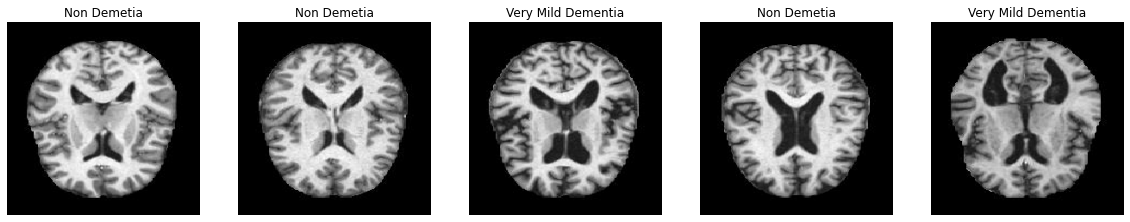

In [3]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))
for i in range(5):
    rand1 = np.random.randint(len(train_data))
    rand2 = np.random.randint(60)
    ax[i].imshow(train_data[rand1][0][rand2])
    ax[i].axis('off')
    a = train_data[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

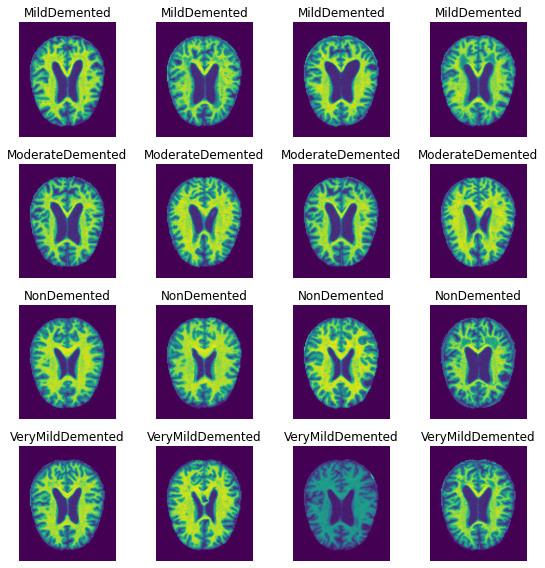

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_folder = 'F:\Alzheimer_s Dataset\\test'
class_names = os.listdir(test_folder)
num_images_per_class = 4

plt.figure(figsize=(8, 8))

for class_name in class_names:
    class_folder = os.path.join(test_folder, class_name)
    image_files = os.listdir(class_folder)[:num_images_per_class]
    
    for image_file in image_files:
        image_path = os.path.join(class_folder, image_file)
        image = mpimg.imread(image_path)
        
        plt.subplot(len(class_names), num_images_per_class, class_names.index(class_name) * num_images_per_class + image_files.index(image_file) + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

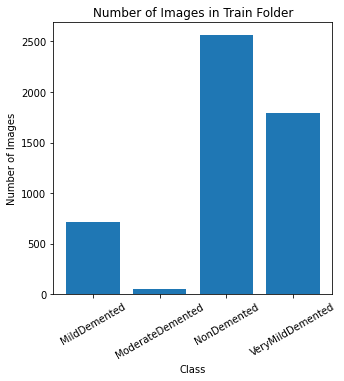

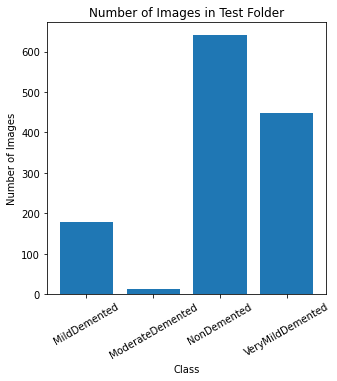

In [5]:
main_folder = 'F:\Alzheimer_s Dataset'

# List of subfolders (train and test)
subfolders = ['train', 'test']
for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    class_names = os.listdir(subfolder_path)
    class_counts = []
    
    for class_name in class_names:
        class_folder = os.path.join(subfolder_path, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts.append(num_images)
    
    plt.figure(figsize=(5,5))
    plt.bar(class_names, class_counts)
    plt.title(f"Number of Images in {subfolder.capitalize()} Folder")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=30)
    plt.show()

Model Building

In [8]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [9]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)
modelvgg16 = Model(inputs=vgg16.input, outputs=out)
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
modelvgg16.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
modelvgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Model Training

In [10]:
hist_vgg16=modelvgg16.fit(train_data, epochs=epoch, steps_per_epoch=10,validation_data=validation_data, callbacks=callback)

Epoch 1/10
86/86 [==============================] - 1120s 13s/step - loss: 1.2488 - accuracy: 0.5874 - val_loss: 0.8317 - val_accuracy: 0.6271
Epoch 2/10
86/86 [==============================] - 861s 10s/step - loss: 0.6526 - accuracy: 0.7231 - val_loss: 0.9404 - val_accuracy: 0.6310
Epoch 3/10
86/86 [==============================] - 895s 10s/step - loss: 0.4582 - accuracy: 0.8178 - val_loss: 0.7623 - val_accuracy: 0.6755
Epoch 4/10
86/86 [==============================] - 905s 11s/step - loss: 0.3362 - accuracy: 0.8844 - val_loss: 0.7829 - val_accuracy: 0.6693
Epoch 5/10
86/86 [==============================] - 951s 11s/step - loss: 0.2936 - accuracy: 0.8930 - val_loss: 0.8609 - val_accuracy: 0.6607
Epoch 6/10
86/86 [==============================] - 887s 10s/step - loss: 0.2248 - accuracy: 0.9289 - val_loss: 1.1026 - val_accuracy: 0.6396
Epoch 7/10
86/86 [==============================] - 898s 10s/step - loss: 0.1637 - accuracy: 0.9586 - val_loss: 0.8703 - val_accuracy: 0.6818
Epoch

In [12]:
loss_vgg16,accuracy_vgg16 = modelvgg16.evaluate(validation_data)

22/22 [==============================] - 170s 8s/step - loss: 0.9177 - accuracy: 0.6919


by diffrent method on ADNI Dataset

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


In [3]:
WORK_DIR = './Alzheimers-ADNI'

CLASSES = [ 'Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

IMG_SIZE = 224
IMAGE_SIZE = [224, 224]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 1296 images belonging to 5 classes.


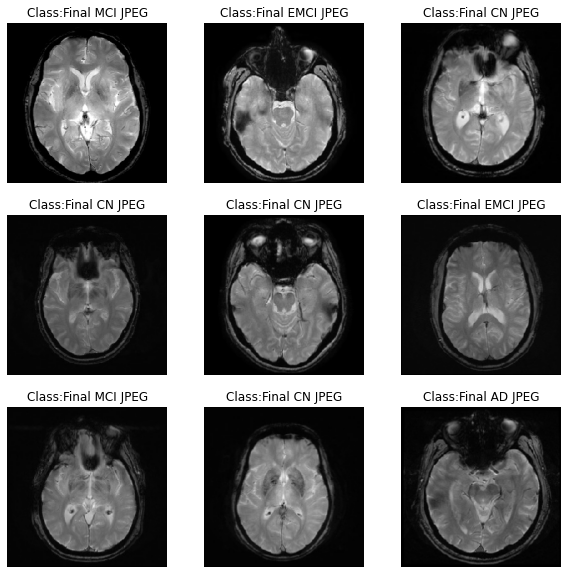

In [5]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1296)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
print(train_data.shape, train_labels.shape)

(1296, 224, 224, 3) (1296, 5)


In [8]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2900, 224, 224, 3) (2900, 5)


In [16]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [17]:
vgg16_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [18]:
for layer in vgg16_model.layers:
    layer.trainable=False

In [19]:
custom_vgg16_model = Sequential([
        vgg16_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(5, activation='softmax')        
    ], name = "resnet_cnn_model")

In [20]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_vgg16_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_vgg16_model.summary()

Model: "resnet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 512)          

 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15156037 (57.82 MB)
Trainable params: 438405 (1.67 MB)
Non-trainable params: 14717632 (56.14 MB)
_________________________________________________________________


In [22]:
EPOCHS = 15

history = custom_vgg16_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,steps_per_epoch=128)

Epoch 1/15
128/128 [==============================] - 419s 3s/step - loss: 2.1010 - accuracy: 0.7493 - precision: 0.2086 - recall: 0.0908 - auc: 0.5078 - f1_score: 0.1246 - val_loss: 1.6040 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5495 - val_f1_score: 0.0000e+00
Epoch 2/15
128/128 [==============================] - 393s 3s/step - loss: 1.8469 - accuracy: 0.7712 - precision: 0.2870 - recall: 0.0971 - auc: 0.5592 - f1_score: 0.1411 - val_loss: 1.5676 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6027 - val_f1_score: 0.0000e+00
Epoch 3/15
128/128 [==============================] - 407s 3s/step - loss: 1.7381 - accuracy: 0.7815 - precision: 0.3261 - recall: 0.0866 - auc: 0.5786 - f1_score: 0.1339 - val_loss: 1.5076 - val_accuracy: 0.8026 - val_precision: 0.8750 - val_recall: 0.0151 - val_auc: 0.6535 - val_f1_score: 0.0277
Epoch 4/15
128/128 [==============================] - 422s 3s/step - loss: 1.66

In [23]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_vgg16_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

19/19 [==============================] - 79s 4s/step - loss: 1.1925 - accuracy: 0.8252 - precision: 0.6911 - recall: 0.2276 - auc: 0.8094 - f1_score: 0.3254
Testing Accuracy: 82.52%


In [27]:
from keras.preprocessing import image
path="F:\Alzheimers-ADNI\\test\\Final AD JPEG\\ADNI_002_S_4521_MR_Axial_T2-Star__br_raw_20160324122521837_22_S402609_I662501.jpg"
img=image.load_img(path,target_size=(224,224))

In [29]:
pred_labels = custom_vgg16_model.predict(test_data)

19/19 [==============================] - 91s 5s/step


In [25]:
print(pred_labels)

[[0.20255844 0.12527117 0.227015   0.06463403 0.3805214 ]
 [0.21385705 0.25677553 0.286354   0.02448442 0.21852893]
 [0.14773883 0.31996864 0.15179415 0.02292936 0.35756907]
 ...
 [0.6944574  0.11276526 0.14440356 0.0119538  0.03641995]
 [0.08164679 0.04939018 0.113995   0.6013677  0.1536003 ]
 [0.15408197 0.22184727 0.22382894 0.05383531 0.3464065 ]]


In [30]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.47      0.47      0.47       112
  Final CN JPEG       0.44      0.54      0.48       125
Final EMCI JPEG       0.31      0.09      0.14       117
Final LMCI JPEG       0.66      0.87      0.75       116
 Final MCI JPEG       0.34      0.38      0.36       110

      micro avg       0.47      0.47      0.47       580
      macro avg       0.44      0.47      0.44       580
   weighted avg       0.44      0.47      0.44       580
    samples avg       0.47      0.47      0.47       580



In [31]:
custom_vgg16_model.save('vgg16ADNI2.keras') 
print('Model Saved!')

Model Saved!
